# Team- LossLess Crew

# Start-up Founder Retention Prediction
## Automated Pipeline with Hyperparameter Tuning

This notebook outlines a machine learning pipeline to predict whether a start-up founder will stay or leave.
**Steps covered:**
1. Data Loading & Cleaning
2. Outlier Detection (IQR Method)
3. Feature Engineering (Ordinal & One-Hot Encoding)
4. Hyperparameter Tuning (Logistic Regression, SVM, MLP)
5. Final Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore') # Clean up output

## 1. Load Data
We load the training and testing datasets and separate the IDs for the final submission.

In [2]:
# Assuming files are in the current directory or updated path
# Update the path below if running locally instead of Kaggle
train_df = pd.read_csv('/kaggle/input/data-set/train.csv')
test_df = pd.read_csv('/kaggle/input/data-set/test.csv')

# Store IDs for final submission
test_ids = test_df['founder_id']

# Drop ID column from both
train_df = train_df.drop(columns=['founder_id'])
test_df = test_df.drop(columns=['founder_id'])

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

Train Shape: (59611, 23)
Test Shape: (14900, 22)


## 2. Data Cleaning & Imputation
Here we remove duplicates, encode the target variable, and fill missing values using:
- **Median** for numerical columns.
- **Mode (Most Frequent)** for categorical columns.

In [3]:
print("--- Step 1: Data Cleaning ---")

# Remove Duplicates
initial_rows = train_df.shape[0]
train_df = train_df.drop_duplicates()
print(f"Removed {initial_rows - train_df.shape[0]} duplicate rows.")

# Separate Features and Target
X = train_df.drop(columns=['retention_status'])
y = train_df['retention_status']

# Encode Target (Stayed -> 1, Left -> 0)
le_target = LabelEncoder()
y = le_target.fit_transform(y)
print(f"Target encoded. Classes: {le_target.classes_}")

# Identify Column Types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Impute Missing Values
print("Imputing missing values...")
num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])
test_df[numerical_cols] = num_imputer.transform(test_df[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])
test_df[categorical_cols] = cat_imputer.transform(test_df[categorical_cols])

--- Step 1: Data Cleaning ---
Removed 13 duplicate rows.
Target encoded. Classes: ['Left' 'Stayed']
Imputing missing values...


## EXPLORATORY DATA ANALYSIS (EDA)

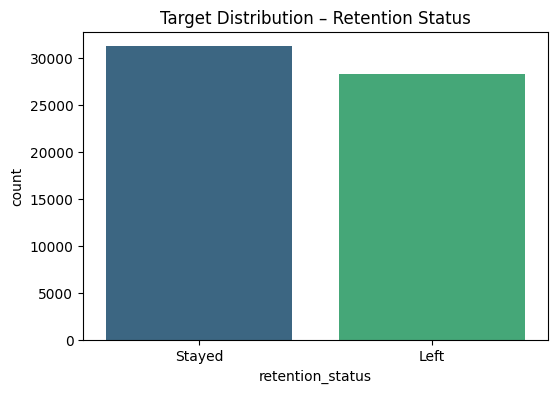

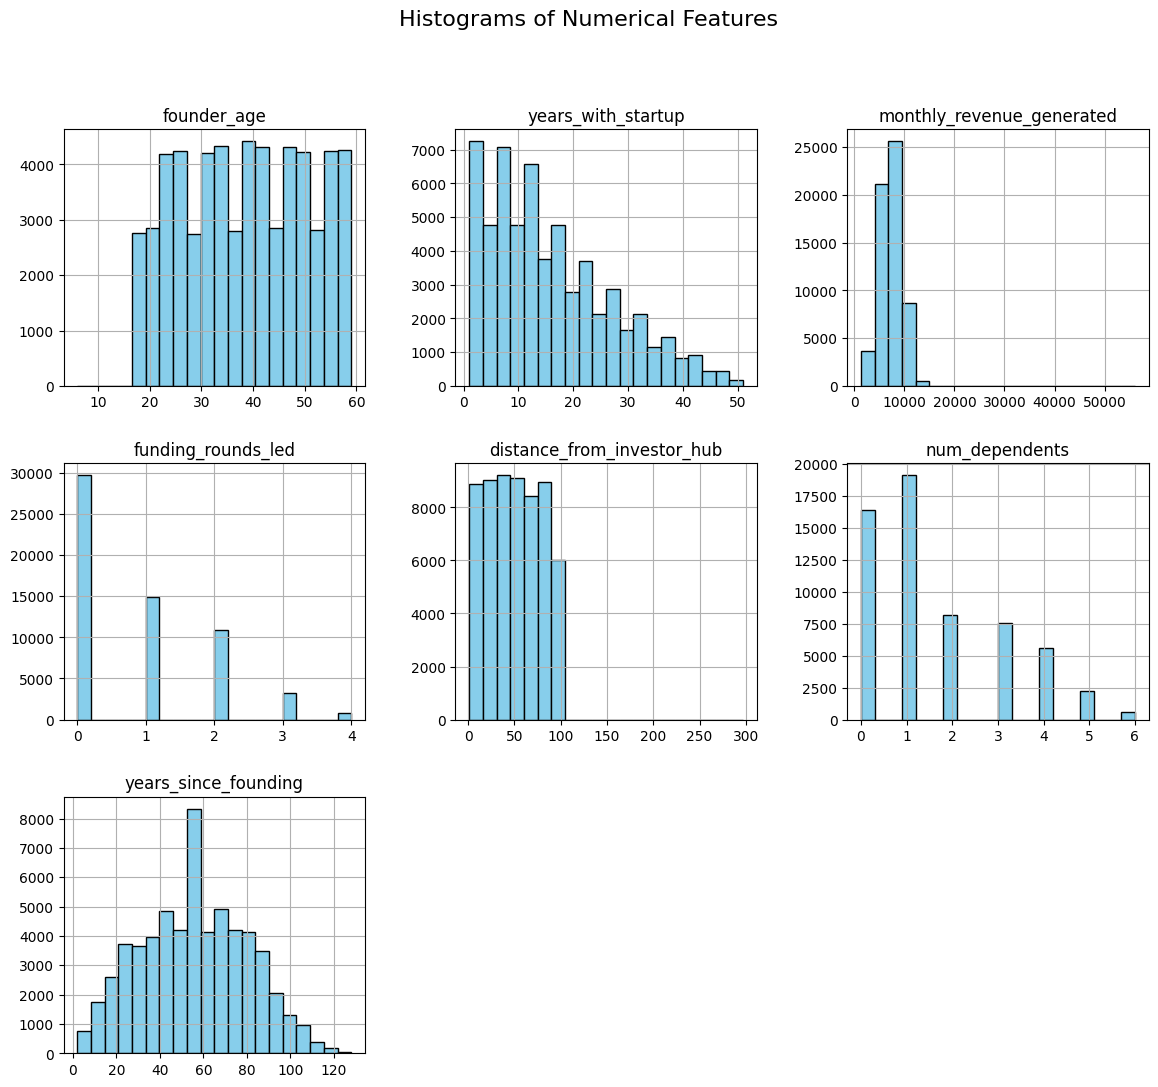

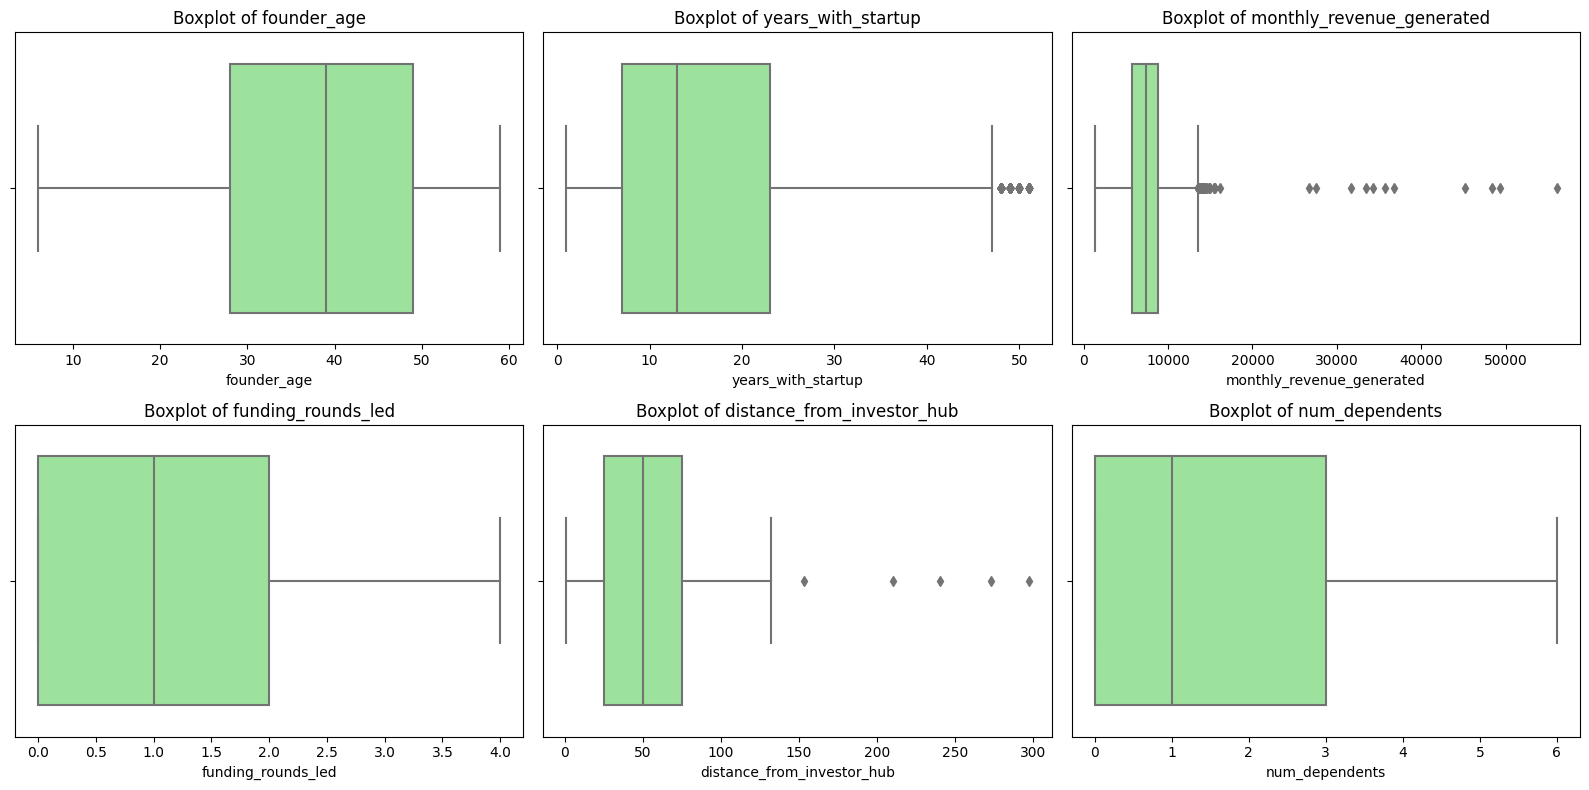

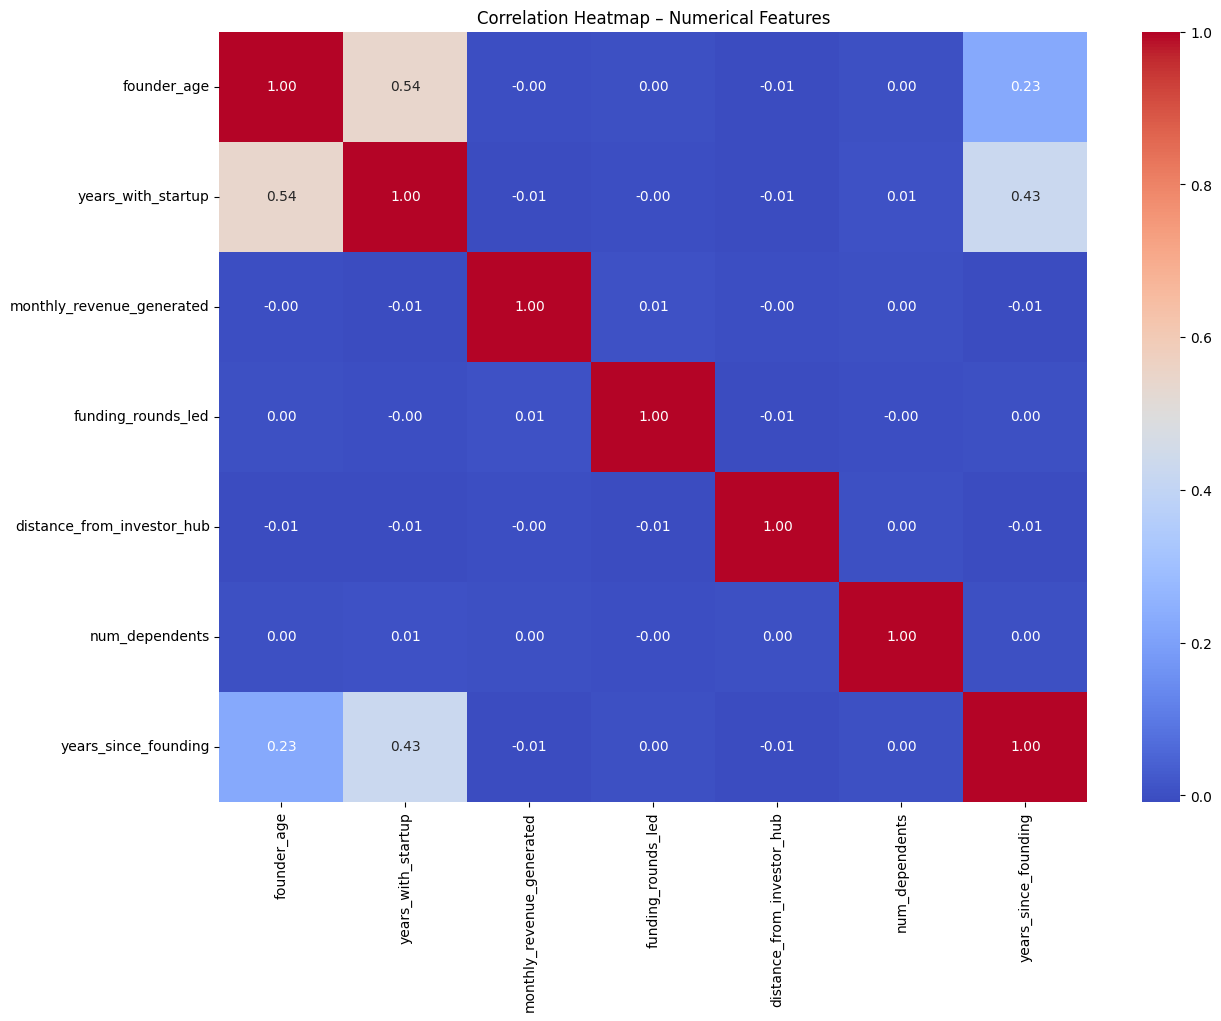

In [4]:


# --- Target Distribution ---
plt.figure(figsize=(6,4))
sns.countplot(x=train_df['retention_status'], palette="viridis")
plt.title("Target Distribution – Retention Status")
plt.show()

# --- Histograms for Numeric Columns ---
X[numerical_cols].hist(figsize=(14,12), bins=20, color="skyblue", edgecolor="black")
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

# --- Boxplots for Outlier Detection ---
plt.figure(figsize=(16,8))
for i, col in enumerate(numerical_cols[:6]):  # Only first 6 to avoid too many plots
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=X[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(14,10))
corr = X[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap – Numerical Features")
plt.show()


## 3. Outlier Detection
We apply the **IQR (Interquartile Range) Capping** method to handle extreme values in numerical features.

In [5]:
print("\n--- Step 2: Outlier Detection (Capping) ---")

def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

X = cap_outliers(X, numerical_cols)
test_df = cap_outliers(test_df, numerical_cols)
print(f"Outliers capped for columns: {numerical_cols}")


--- Step 2: Outlier Detection (Capping) ---
Outliers capped for columns: ['founder_age', 'years_with_startup', 'monthly_revenue_generated', 'funding_rounds_led', 'distance_from_investor_hub', 'num_dependents', 'years_since_founding']


## 4. Feature Encoding
We separate encoding strategies based on the nature of the data:
1. **Ordinal Encoding:** For data with a clear rank (e.g., 'Low', 'Medium', 'High').
2. **One-Hot Encoding:** For nominal data with no inherent order.

In [6]:
print("\n--- Step 3: Feature Encoding ---")

# A. Ordinal features
ordinal_mappings = {
    'work_life_balance_rating': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3},
    'venture_satisfaction': {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3},
    'startup_performance_rating': {'Low': 0, 'Below Average': 1, 'Average': 2, 'High': 3},
    'startup_stage': {'Entry': 0, 'Mid': 1, 'Senior': 2},
    'team_size_category': {'Small': 0, 'Medium': 1, 'Large': 2},
    'founder_visibility': {'Low': 0, 'Medium': 1, 'High': 2, 'Very High': 3},
    'startup_reputation': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
}

for col, mapping in ordinal_mappings.items():
    if col in X.columns:
        X[col] = X[col].map(mapping)
        test_df[col] = test_df[col].map(mapping)

print("Ordinal variables encoded.")

# B. One-Hot Encoding (Remaining object columns)
nominal_cols = X.select_dtypes(include=['object']).columns.tolist()

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_ohe = pd.DataFrame(ohe.fit_transform(X[nominal_cols]))
test_ohe = pd.DataFrame(ohe.transform(test_df[nominal_cols]))

X_ohe.columns = ohe.get_feature_names_out(nominal_cols)
test_ohe.columns = ohe.get_feature_names_out(nominal_cols)

# Concatenate back
X = pd.concat([X.drop(columns=nominal_cols).reset_index(drop=True), X_ohe], axis=1)
test_df = pd.concat([test_df.drop(columns=nominal_cols).reset_index(drop=True), test_ohe], axis=1)

print(f"One-Hot Encoding applied. Final Feature Count: {X.shape[1]}")


--- Step 3: Feature Encoding ---
Ordinal variables encoded.
One-Hot Encoding applied. Final Feature Count: 37


## 5. Scaling & Splitting
Standardize features to mean=0 and variance=1. Split data to evaluate model performance before final submission.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_df)

# Split for final evaluation before submission
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Data scaled and split.")

Data scaled and split.


## 6. Hyperparameter Tuning
We use **GridSearchCV** to test three different algorithms:
1. **Logistic Regression** (Baseline linear model)
2. **Linear SVC** (Support Vector Machine)
3. **MLP Classifier** (Neural Network)

In [8]:
print("\n--- Step 4: Hyperparameter Tuning ---")

# Define parameter grids
param_grids = {
    "Logistic Regression": {
        'model': LogisticRegression(max_iter=2000, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    "SVM (Linear)": {
        'model': LinearSVC(dual=False, max_iter=3000, random_state=42),
        'params': {
            'C': [0.1, 1, 10]
        }
    },
    "Neural Network": {
        'model': MLPClassifier(max_iter=500, early_stopping=True, random_state=42),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'alpha': [0.0001, 0.001],
            'learning_rate_init': [0.001, 0.01]
        }
    }
}

best_overall_model = None
best_overall_score = 0
best_model_name = ""

# Loop through models and tune
for name, config in param_grids.items():
    print(f"\nTuning {name}...")
    
    # GridSearchCV with 3-fold cross-validation
    clf = GridSearchCV(
        config['model'], 
        config['params'], 
        cv=3, 
        scoring='accuracy', 
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    
    clf.fit(X_train, y_train)
    
    print(f"  Best Params: {clf.best_params_}")
    print(f"  Best CV Accuracy: {clf.best_score_:.4f}")
    
    # Evaluate on Validation Set
    val_pred = clf.best_estimator_.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"  Validation Accuracy: {val_acc:.4f}")
    
    if val_acc > best_overall_score:
        best_overall_score = val_acc
        best_overall_model = clf.best_estimator_
        best_model_name = name

print(f"\n" + "="*50)
print(f"WINNER: {best_model_name} with Accuracy {best_overall_score:.4f}")
print(f"="*50)


--- Step 4: Hyperparameter Tuning ---

Tuning Logistic Regression...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  Best Params: {'C': 1, 'solver': 'liblinear'}
  Best CV Accuracy: 0.7428
  Validation Accuracy: 0.7417

Tuning SVM (Linear)...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
  Best Params: {'C': 0.1}
  Best CV Accuracy: 0.7425
  Validation Accuracy: 0.7417

Tuning Neural Network...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  Best Params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01}
  Best CV Accuracy: 0.7437
  Validation Accuracy: 0.7435

WINNER: Neural Network with Accuracy 0.7435


## 7. Submission
Retrain the best model on the **entire** dataset (Train + Validation) and generate the CSV.

In [9]:
print(f"\nRetraining {best_model_name} on the full dataset...")

# Retrain the best model on ALL available training data (X_scaled, y)
best_overall_model.fit(X_scaled, y)

# Predict on Test Data
print("Generating predictions on Test set...")
final_predictions_encoded = best_overall_model.predict(test_scaled)

# Convert back to original labels ('Stayed', 'Left')
final_predictions_labels = le_target.inverse_transform(final_predictions_encoded)

# Generate Submission DataFrame
submission = pd.DataFrame({
    "founder_id": test_ids,
    "retention_status": final_predictions_labels
})

# Save file
submission.to_csv("submission_hyper.csv", index=False)
print("\nSuccess! Submission file created: submission_hyper.csv")
print(submission.head())


Retraining Neural Network on the full dataset...
Generating predictions on Test set...

Success! Submission file created: submission_hyper.csv
   founder_id retention_status
0       52685           Stayed
1       30585             Left
2       54656           Stayed
3       33442             Left
4       15667           Stayed


# Train SVM and Neural Network on small 20% training data

In [2]:
# ---------------------------------------------------------
# 1. LOAD DATA
# ---------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load training file
df = pd.read_csv('/kaggle/input/data-set/train.csv')

# Target and features
test_ids = df['founder_id']
df = df.drop(columns=['founder_id'])

X = df.drop(columns=['retention_status'])
y = df['retention_status']

le = LabelEncoder()
y = le.fit_transform(y)

# ---------------------------------------------------------
# 2. IMPUTATION + SCALING
# ---------------------------------------------------------
num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])
X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])

# Encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------------------------------------
# 3. TRAIN/TEST SPLIT (20% train, 80% test)
# ---------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.80, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples :", X_test.shape[0])

# ---------------------------------------------------------
# 4. TRAIN **SVM** ON SMALL DATA (20% TRAIN)
# ---------------------------------------------------------
svm_model = LinearSVC(C=1.0, max_iter=3000, random_state=42)
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)

print("\n===== SVM Results =====")
print("Accuracy:", svm_acc)
print(classification_report(y_test, svm_pred))

# ---------------------------------------------------------
# 5. TRAIN **Neural Network** ON SMALL DATA (20% TRAIN)
# ---------------------------------------------------------
nn_model = MLPClassifier(hidden_layer_sizes=(50,),
                         learning_rate_init=0.01,
                         max_iter=500,
                         early_stopping=True,
                         random_state=42)

nn_model.fit(X_train, y_train)

nn_pred = nn_model.predict(X_test)
nn_acc = accuracy_score(y_test, nn_pred)

print("\n===== Neural Network Results =====")
print("Accuracy:", nn_acc)
print(classification_report(y_test, nn_pred))

# ---------------------------------------------------------
# 6. FINAL COMPARISON
# ---------------------------------------------------------
print("\n===============================")
print(" FINAL COMPARISON (20% TRAIN)")
print("===============================")
print(f"SVM Accuracy          : {svm_acc:.4f}")
print(f"Neural Network Accuracy : {nn_acc:.4f}")

if svm_acc > nn_acc:
    print("\n➡️ SVM performs better on SMALL datasets.")
else:
    print("\n➡️ Neural Network performs better.")


Training samples: 11922
Testing samples : 47689


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== SVM Results =====
Accuracy: 0.7435467298538447
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     22677
           1       0.75      0.76      0.76     25012

    accuracy                           0.74     47689
   macro avg       0.74      0.74      0.74     47689
weighted avg       0.74      0.74      0.74     47689


===== Neural Network Results =====
Accuracy: 0.7382624923986664
              precision    recall  f1-score   support

           0       0.73      0.72      0.72     22677
           1       0.75      0.75      0.75     25012

    accuracy                           0.74     47689
   macro avg       0.74      0.74      0.74     47689
weighted avg       0.74      0.74      0.74     47689


 FINAL COMPARISON (20% TRAIN)
SVM Accuracy          : 0.7435
Neural Network Accuracy : 0.7383

➡️ SVM performs better on SMALL datasets.
